In [38]:
import sys
import asyncio
import aiohttp
sys.path.append('/Users/andreas/fun/useful_py_func/pyTibber/tibber/')
#sys.path.append('/home/andram/fun/LED-env/lib/python3.11/site-packages/tibber')
from tibber import Tibber, gql_queries
from datetime import datetime 
import numpy
import matplotlib.pyplot as plt

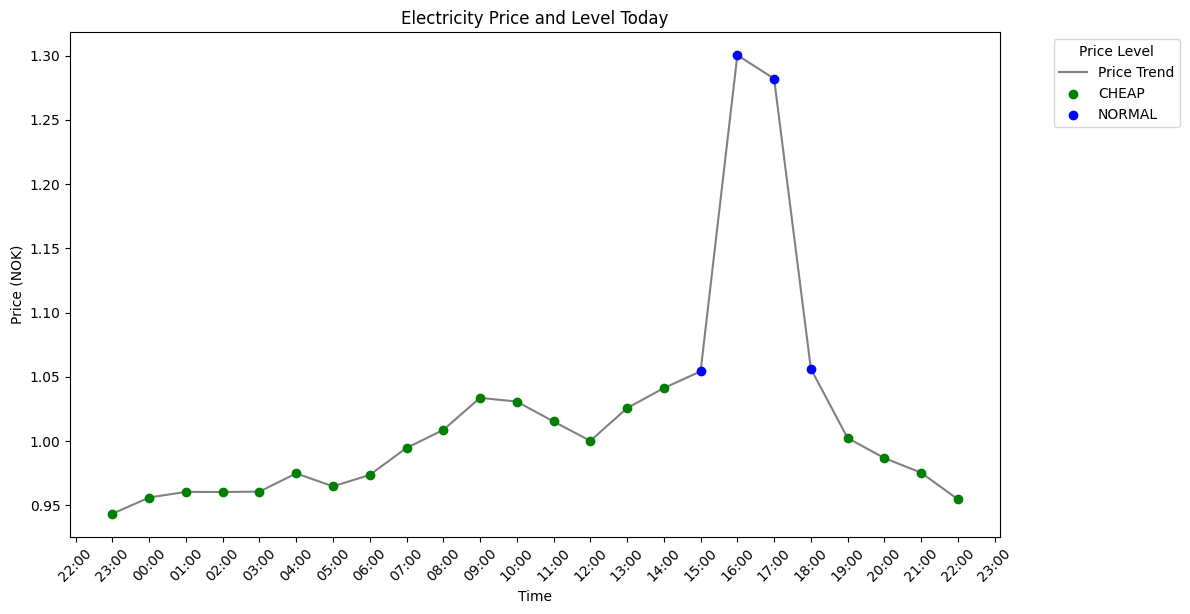

In [50]:
import asyncio
from tibber import Tibber, gql_queries
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil import parser

async def main():
    TOKEN = "U4L8yS_OHsfgKndAhNQZ8K-JYElbNUagYvToCF3ZPVE"
    USER_AGENT = "LED_client"
    HOME_ID = "975996b6-e7ca-4fbf-9f72-61e2df95bc0c"

    tibber_connection = Tibber(TOKEN, user_agent=USER_AGENT)
    await tibber_connection.update_info()
    
    # Fetch price information for today
    query = gql_queries.PRICE_INFO % HOME_ID
    data = await tibber_connection.execute(query)
    
    # Extract price information
    today_prices = data['viewer']['home']['currentSubscription']['priceInfo']['today']
    
    # Preparing data for plotting
    times = [parser.parse(price['startsAt']) for price in today_prices]
    prices = [price['total'] for price in today_prices]
    levels = [price['level'] for price in today_prices]

    await tibber_connection.close_connection()

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))

    # Mapping of levels to colors for plotting
    level_colors = {
        'NORMAL': 'blue',
        'CHEAP': 'green',
        'VERY_CHEAP': 'lightgreen',
        'EXPENSIVE': 'orange',
        'VERY_EXPENSIVE': 'red'
    }

    # Plot lines connecting the scatter points
    ax.plot(times, prices, color='grey', label='Price Trend', linestyle='-', marker='', zorder=1)

    # Plot each price point with a color indicating its level
    for time, price, level in zip(times, prices, levels):
        ax.scatter(time, price, color=level_colors[level], label=level if level not in ax.get_legend_handles_labels()[1] else "", zorder=2)

    ax.set_xlabel('Time')
    ax.set_ylabel('Price (NOK)')

    # Custom legend handling to ensure each level is represented once
    handles, labels = ax.get_legend_handles_labels()
    # Create a legend mapping each price level to its color, plus the price trend line
    legend_labels = {label: handle for handle, label in zip(handles, labels)}
    ax.legend(legend_labels.values(), legend_labels.keys(), title='Price Level', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Format the x-axis to show dates and times more clearly
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    plt.title('Electricity Price and Level Today')
    plt.tight_layout()  # Adjust layout
    plt.xticks(rotation=45)
    plt.show()

await main()


In [ ]:
ACCESS_TOKEN = "U4L8yS_OHsfgKndAhNQZ8K-JYElbNUagYvToCF3ZPVE"
USER_AGENT = "LED_client"
PRICE_QUERY_INTERVAL = 10  # Interval in seconds (e.g., 3600 seconds for hourly updates)

def _callback(pkg):
    print("Real-time data received:", pkg)

async def fetch_price_level(tibber_connection):
    i = 0
    query = '''
    {
      viewer {
        homes {
          currentSubscription {
            priceInfo {
              current {
                level
              }
            }
          }
        }
      }
    }
    '''
    while True:
        i +=1
        if i>= 3:
            break
        else:
            print('i:',i)
        
        data = await tibber_connection.execute(query)
        if data:
            for home in data['viewer']['homes']:
                if home.get('currentSubscription') and home['currentSubscription'].get('priceInfo'):
                    current_price_info = home['currentSubscription']['priceInfo'].get('current')
                    if current_price_info:
                        print(f"Current Price Level: {current_price_info['level']}")
        await asyncio.sleep(PRICE_QUERY_INTERVAL)

async def run():
    async with aiohttp.ClientSession() as session:
        tibber_connection = Tibber(ACCESS_TOKEN, websession=session, user_agent=USER_AGENT)
        await tibber_connection.update_info()

        # Start the periodic task for fetching price level
        asyncio.create_task(fetch_price_level(tibber_connection))
        
        while True:
            await asyncio.sleep(10)

await run()


In [51]:
import asyncio
import datetime as dt
import aiohttp
from tibber import Tibber, InvalidLoginError, FatalHttpExceptionError, RetryableHttpExceptionError

class MicroBitCommunicator:
    @staticmethod
    async def update_micro_bit(price_level):
        print(f"Updating micro-bit with new price level: {price_level}")
        # Add code to send data to micro-bit.

class TibberAPI:
    MAX_RETRIES = 5

    def __init__(self, access_token: str, user_agent: str = "Tibber_Client_1"):
        self._access_token = access_token
        self._user_agent = user_agent
        self._tibber_connection = None
        self.last_price_level = None
        self.retry_count = 0

    async def connect(self):
        self._session = aiohttp.ClientSession()
        self._tibber_connection = Tibber(self._access_token, websession=self._session, user_agent=self._user_agent)
        while self.retry_count < self.MAX_RETRIES:
            try:
                await self._tibber_connection.update_info()
                break
            except Exception as e:
                self.retry_count += 1
                print(f"Attempt {self.retry_count}/{self.MAX_RETRIES} failed: {e}")
                await asyncio.sleep(2 ** self.retry_count)  # Exponential back-off
            if self.retry_count >= self.MAX_RETRIES:
                print("Maximum retry attempts reached. Exiting.")

    async def close_connection(self):
        if self._session:
            await self._session.close()

    async def fetch_price_info(self, home_id: str):
        home = self._tibber_connection.get_home(home_id)
        if home is None:
            raise ValueError(f"No Tibber home found with ID: {home_id}")

        while True:
            try:
                # Fetch immediately if the last price level is None
                if self.last_price_level is None:
                    await home.update_info()
                    print("API called: fetch price info.")
                    if home.current_price_info:
                        current_price_level = home.current_price_info.get('level')
                        print(f"Current Price Level for {home_id}: {current_price_level}")
                        if current_price_level != self.last_price_level:
                            self.last_price_level = current_price_level
                            await MicroBitCommunicator.update_micro_bit(current_price_level)
                
                # Calculate delay for the next hourly update
                next_hour = dt.datetime.now(dt.timezone.utc).replace(minute=0, second=0, microsecond=0) + dt.timedelta(hours=1)
                #delay = (next_hour - dt.datetime.now(dt.timezone.utc)).total_seconds()
                delay = 10
                print(f"Delay for next update: {round(delay)} [s]")
                await asyncio.sleep(delay)

                # Fetch after the delay
                await home.update_info()
                print("API called: fetch price info.")
                if home.current_price_info:
                    current_price_level = home.current_price_info.get('level')
                    print(f"Current Price Level for {home_id}: {current_price_level}")
                    if current_price_level != self.last_price_level:
                        self.last_price_level = current_price_level
                        await MicroBitCommunicator.update_micro_bit(current_price_level)
            except Exception as e:
                print(f"Error in fetch_price_info: {e}")
                await asyncio.sleep(60)  # Wait a bit before retrying

async def main():
    access_token = "U4L8yS_OHsfgKndAhNQZ8K-JYElbNUagYvToCF3ZPVE"  
    home_id = "975996b6-e7ca-4fbf-9f72-61e2df95bc0c"
    tibber_api = TibberAPI(access_token)
    await tibber_api.connect()
    if tibber_api._tibber_connection:
        print(f"Connected to Tibber as {tibber_api._tibber_connection.name}")
        asyncio.create_task(tibber_api.fetch_price_info(home_id))
        try:
            while True:
                await asyncio.sleep(60)
        except KeyboardInterrupt:
            print("Stopping the program...")
        await tibber_api.close_connection()

await main()


Connected to Tibber as Erlend Thue
API called: fetch price info.
Delay for next update: 10 [s]
API called: fetch price info.
API called: fetch price info.
Delay for next update: 10 [s]


CancelledError: 

API called: fetch price info.
API called: fetch price info.
Delay for next update: 10 [s]
API called: fetch price info.
API called: fetch price info.
Delay for next update: 10 [s]
API called: fetch price info.
API called: fetch price info.
Delay for next update: 10 [s]
API called: fetch price info.
API called: fetch price info.
Delay for next update: 10 [s]
API called: fetch price info.
API called: fetch price info.
Delay for next update: 10 [s]
API called: fetch price info.
API called: fetch price info.
Delay for next update: 10 [s]
API called: fetch price info.
API called: fetch price info.
Delay for next update: 10 [s]
API called: fetch price info.
API called: fetch price info.
Delay for next update: 10 [s]
API called: fetch price info.
API called: fetch price info.
Delay for next update: 10 [s]
API called: fetch price info.
API called: fetch price info.
Delay for next update: 10 [s]
API called: fetch price info.
API called: fetch price info.
Delay for next update: 10 [s]
API called